$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5.1: Control a Marble with Reinforcement Learning

* A5.1: Details added in Requirements and grading script now available.

Ishani Gowaikar

## Overview

In this assignment, you will be modifying the reinforcement learning code used to solve the dynamic marble problem.  You will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

Start with the code in the notebook for lecture notes 17.

## Requirements

Modify the code from Lecture Notes 17 to change the
reinforcement learning problem to one for which the goal position of
the marble can be varied. In other words, your new code must train one Q network for the marble problem with a variable goal. 

Make the following modifications.

1. To `initialState` add an argument named `goal` with a default value of `None`. In the body of this function, if `goal` is `None` then assign it a random value uniformly distributed between 1 and 9.  Return an initial state with position and velocity as defined before but now with the third component being the goal.
2. To the `reinforcement` function use the goal that is the third component of the first state argument.
3. In `nextState`, make sure that the state that is returned has the same goal as given in the state that is passed in as the first argument.
4. Make several other changes in the code to handle the changes you have made to the state representation.
    

Use the plotting code from Lecture 17 to show your results.  In addition to those plots, create nine additional versions of the lower-right plot for goal positions at 1, 2, 3, 4, 5, 6, 7, 8, and 9.

The general approach is as follows.

The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to modify the reinforcement function to depend on the
current $g_t$ value.

Many of the figures will still make sense.  Include them in your
report.  The contour (and surface)
plots and the plot that tests the marble's behavior for various intial
positions must be produced for a single value of the goal.  Generate
several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how
they vary when the goal is varied.

Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.  Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good parameter values.

Discuss the changes you tried and the results.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn   # from notes 09
import random

In [49]:
import copy
#from copy import copy

actions = (-1, 0, 1)   # Possible actions

def reinforcement(s, s1):
    goal = s[2]
    return 0 if abs(s1[0]-goal) < 1 else -1
    # return -abs(s1[0] - goal)

def initialState(goal = None):
    global target
    if goal is None:
        goal = random.randint(1,9)
    target = goal
    return np.array([10 * np.random.random_sample(), 0.0, goal])

def nextState(s, a):
    goal = s[2]
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0,goal]
    elif s[0] > 10:
        s = [10,0,goal]
    s[2] = goal
    return s

In [50]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

In [51]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon,goal):

    X = np.zeros((numSamples, nnet.n_inputs))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF(goal)
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

In [52]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net, trial, epsilonTrace, rtrace):
    goal = target
    plt.subplot(4, 3, 1)
    plt.plot(epsilonTrace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    plt.subplot(4, 3, 2)
    plt.plot(X[:, 0])
    plt.plot([0, X.shape[0]], [goal, goal], '--', alpha=0.5, lw=5)
    plt.ylabel('$x$')
    plt.ylim(-1, 11)
    qs = net.use(np.array([[s, 0, a, goal] for a in actions for s in range(11)]))
    plt.subplot(4, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')
    plt.subplot(4, 3, 4)
    plt.plot(rtrace[:trial + 1], alpha=0.5)
    binSize = 20
    if trial + 1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)),
                           axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    plt.subplot(4, 3, 5)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[0, 0], X[0, 1], 'o')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([goal-1, goal+1], [-5, -5], [5, 5], color='red', alpha=0.3)
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.subplot(4, 3, 6)
    net.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])
    
    plt.subplot(4, 3, 7)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i], ysflat[i], a, goal] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
    plt.subplot(4, 3, 8)
    acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    s = plt.subplot(4, 3, 10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    s = plt.subplot(4, 3, 11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

In [53]:
def testIt(Qnet, nTrials, nStepsPerTrial):
    goal = target
    xs = np.linspace(0, 10, nTrials)
    plt.subplot(4, 3, 12)
    for x in xs:
        s = [x, 0, goal] # 0 velocity and goal is added here
        xtrace = np.zeros((nStepsPerTrial, 3))######
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
            s = nextState(s, a)
            xtrace[step, :] = s
        plt.plot(xtrace[:, 0], xtrace[:, 1])
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.plot([goal, goal], [-5, 5], '--', alpha=0.5, lw=5)#######
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [54]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

GOAL 1

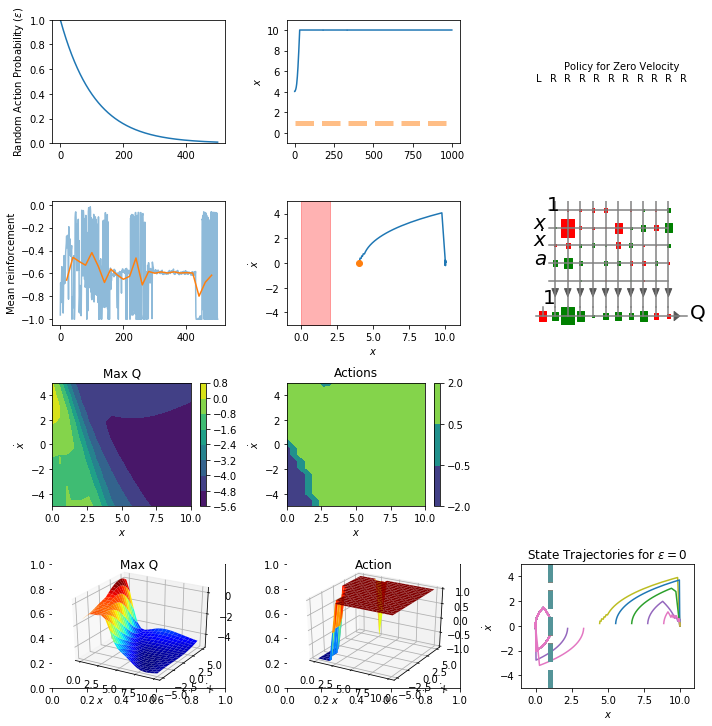

In [8]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 1
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 2

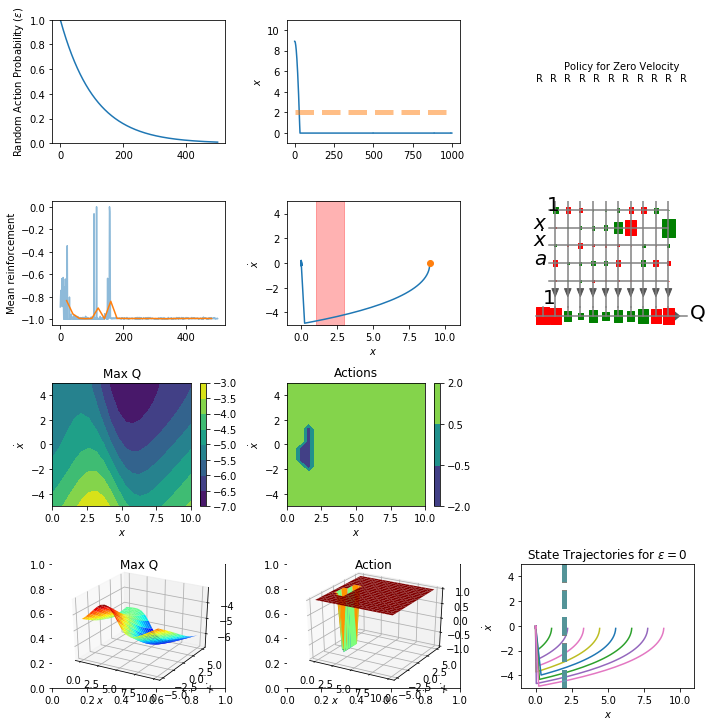

In [9]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 2
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 3

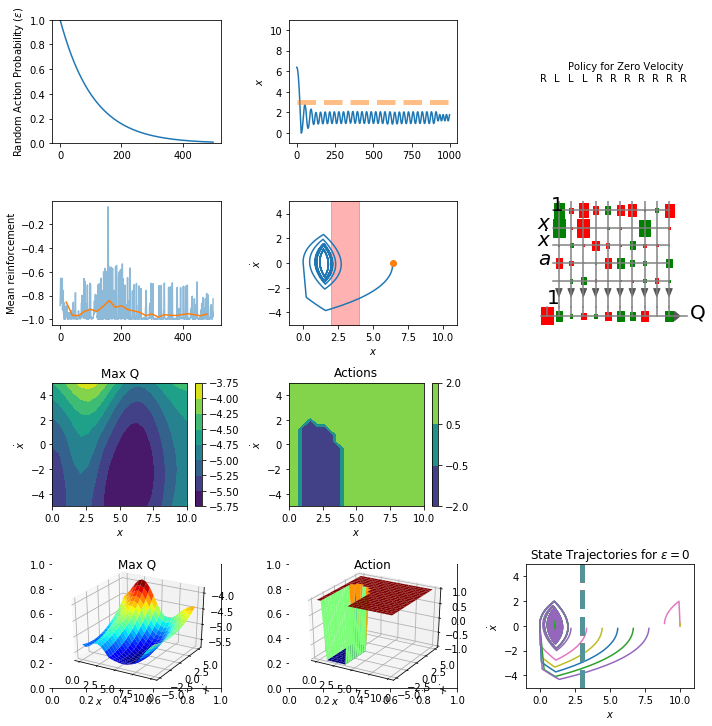

In [10]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 3
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 4

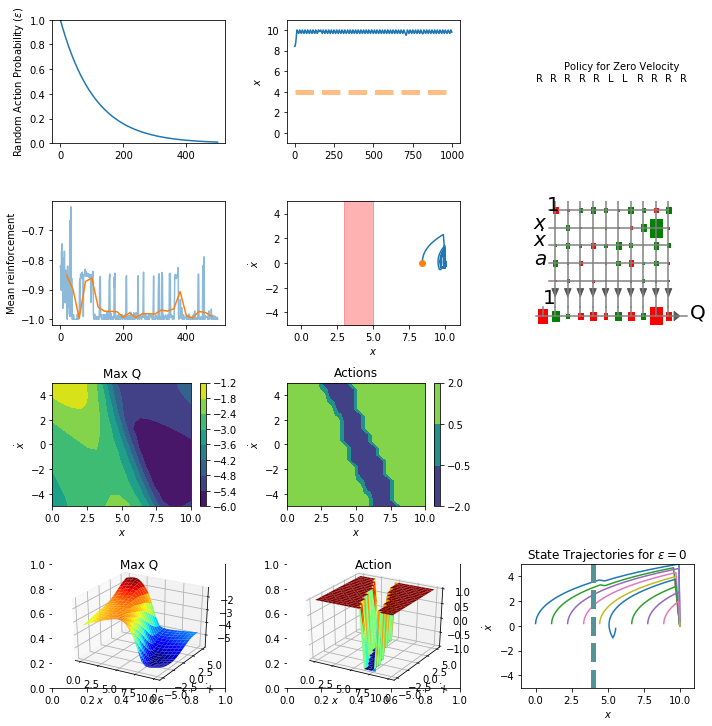

In [11]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 4
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 5

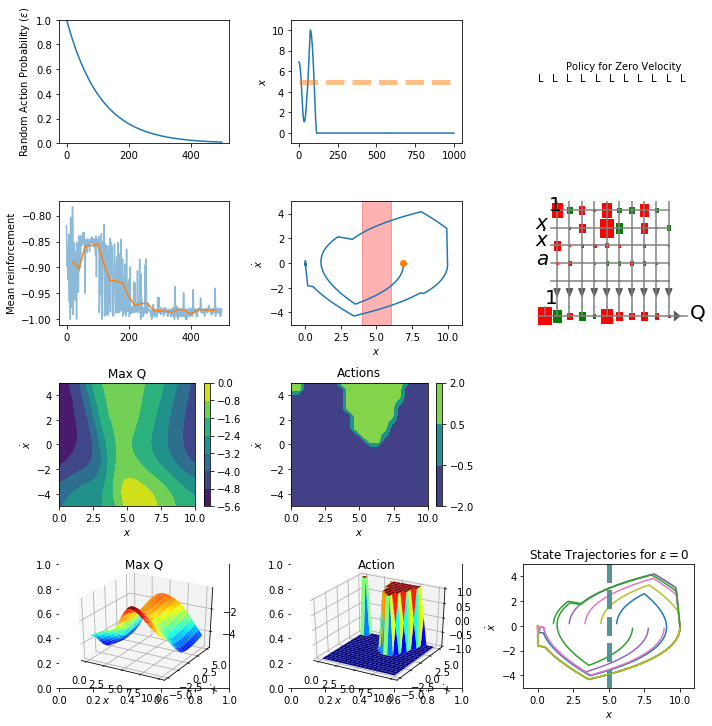

In [12]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 6

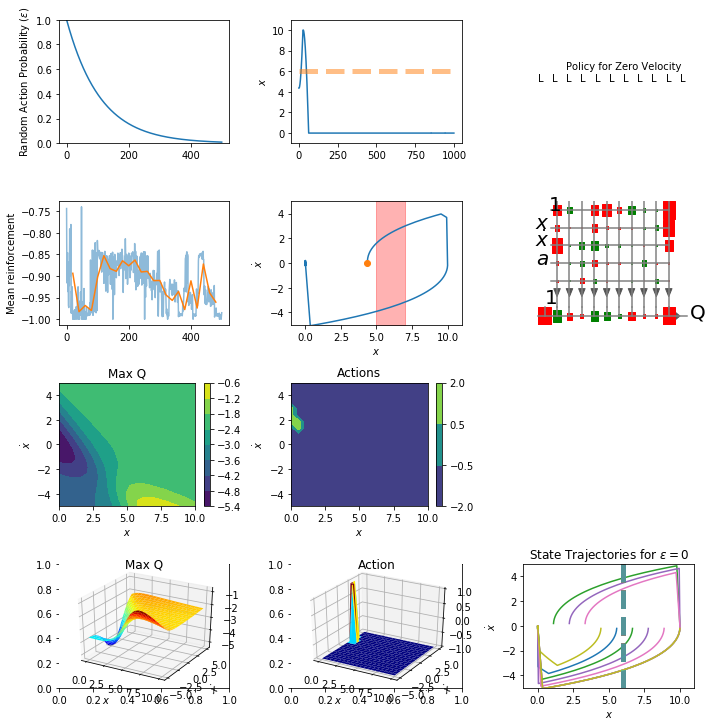

In [13]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 6
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 7

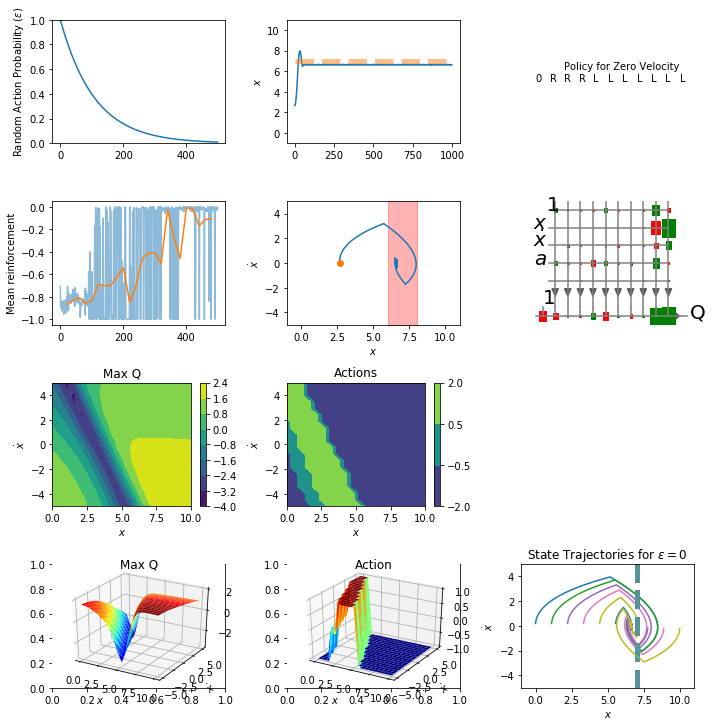

In [14]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 7
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 8

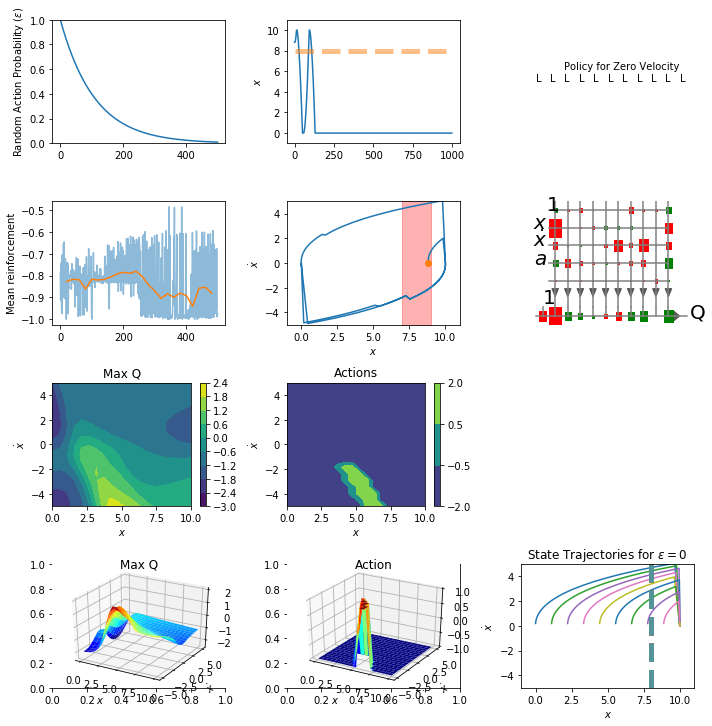

In [15]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 8
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

GOAL 9

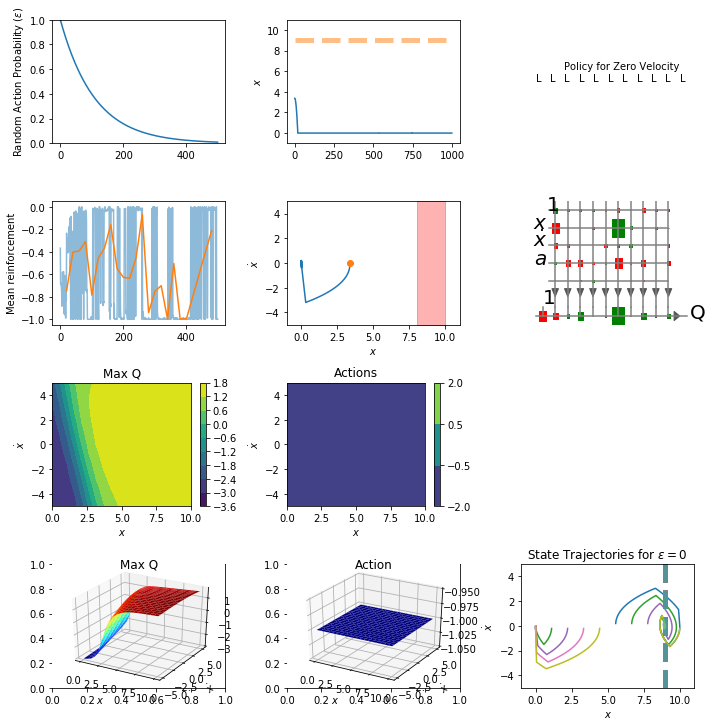

In [16]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 9
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

I have created the testIt plots as well as the surface and contour plots for all the goal positions from 1-9.
From the surface and contour plots for goal position 1, 5 and 9 we can observe that the number of negative actions taken to reach the goal increases as the goal position changes from 1 to 9. That is, the number of positive actions taken to reach goal position 1 is more than that of position 9. For position 5, there are average number of positive and negative actions taken.
Thus, this indicates that the learning rate for goal positions 5 and 9 should be higher than that for goal position 1. This is evident in the contour plots for these positions. Thus, getting to goal 9 is harder than getting to goal 5 and even harder than getting to goal 1. But controlling the marble gets easier with change in the goal positions from 1 to 5 to 9.

## Experiments

## for Number of Trials

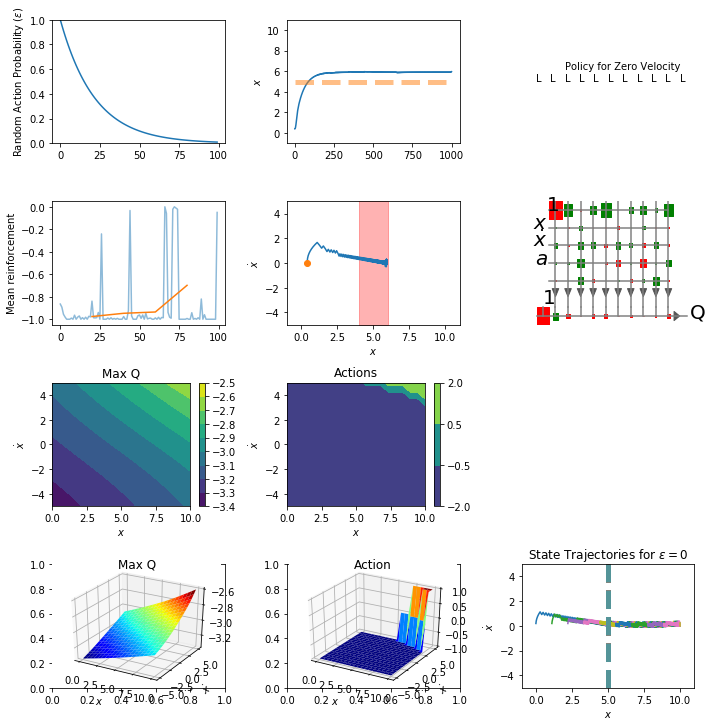

In [21]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 100         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

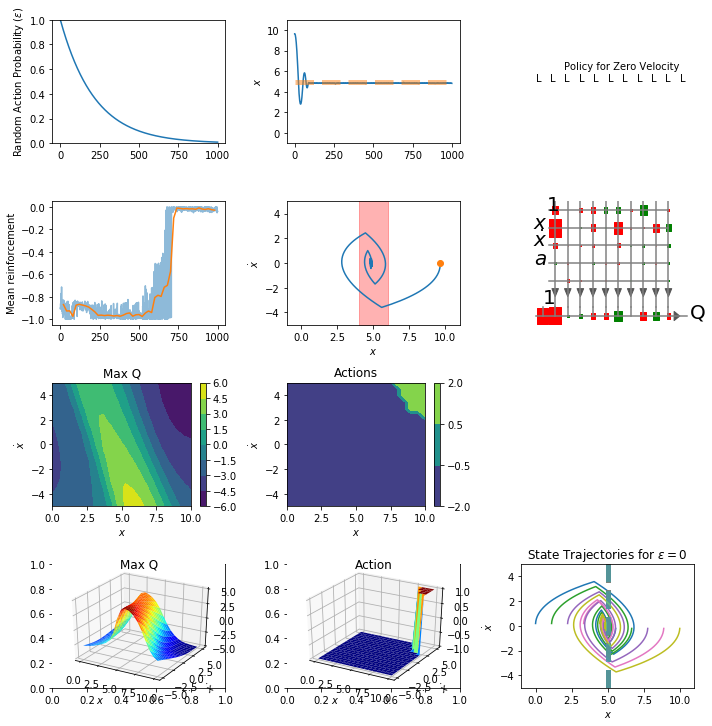

In [22]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 1000         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

Here, the goal position is kept constant which is 5. The original number of trials was 500. Increasing or decreasing the number of trials did not have a positive effect, as the number of negative actions increases, therefore max Q increases, i.e. it becomes slightly harder to get to the goal.

## for Number of Steps per Trial

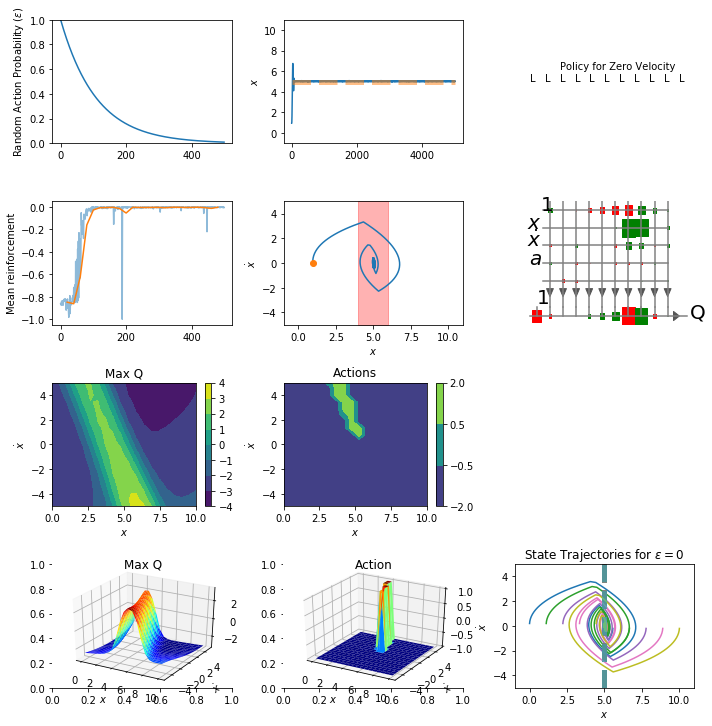

In [23]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 5000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

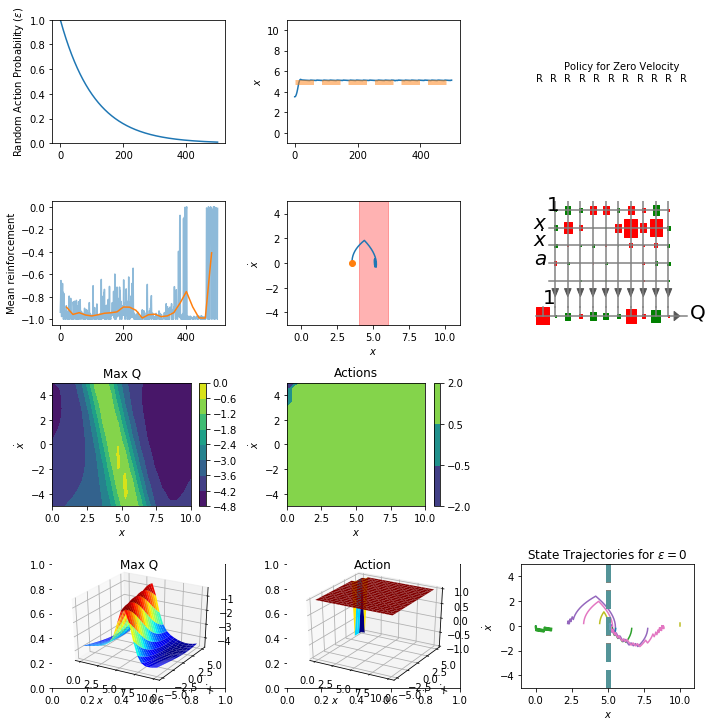

In [24]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 500 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

Decreasing the steps per trial from 1000 to 500  seems to work very well in terms of number of positive actions taken to reach the goal position 5, as compared to increasing the steps per action to 5000. therefore number of steps per trial is best at 500.

## for SCG Iterations

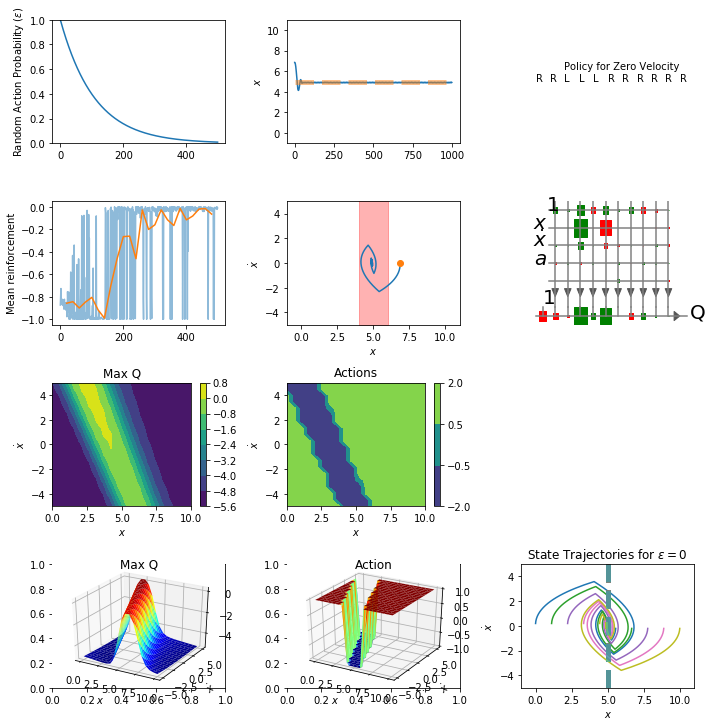

In [25]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

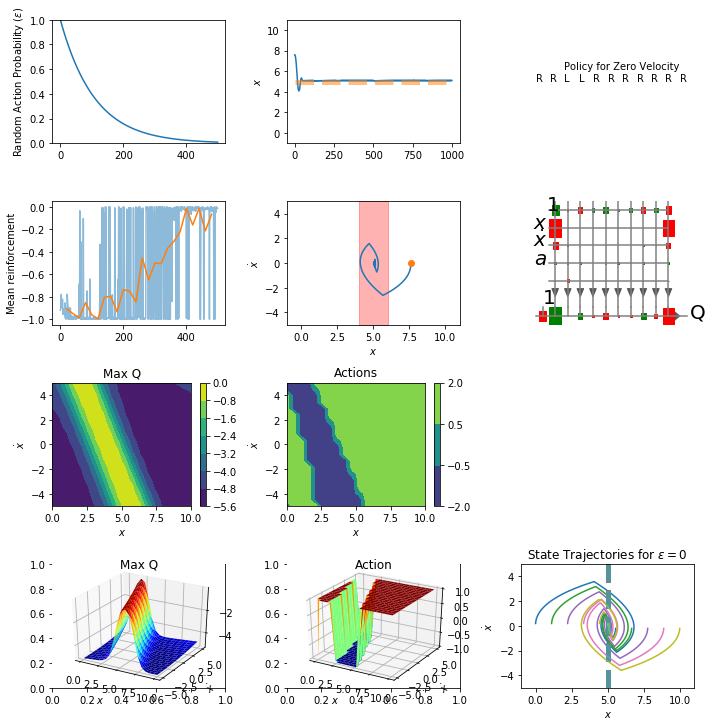

In [26]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 10    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

Increasing the number of SCG iterations seems to work well in terms of balancing the marble at the gaol position. Increasing the number to 5, and then to 10, as can be seen from the contour plots for the max Q, balancing the marble at the required gaol works better for more number of SCG iterations. That is, the marble actually stops at goal position 5, at SCG iterations=10.

## for Final Epsilon

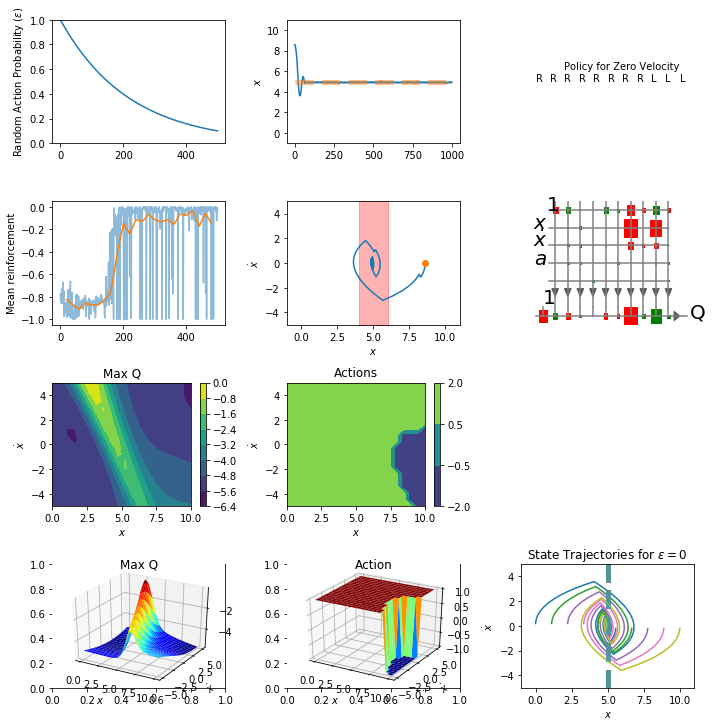

In [27]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.1   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

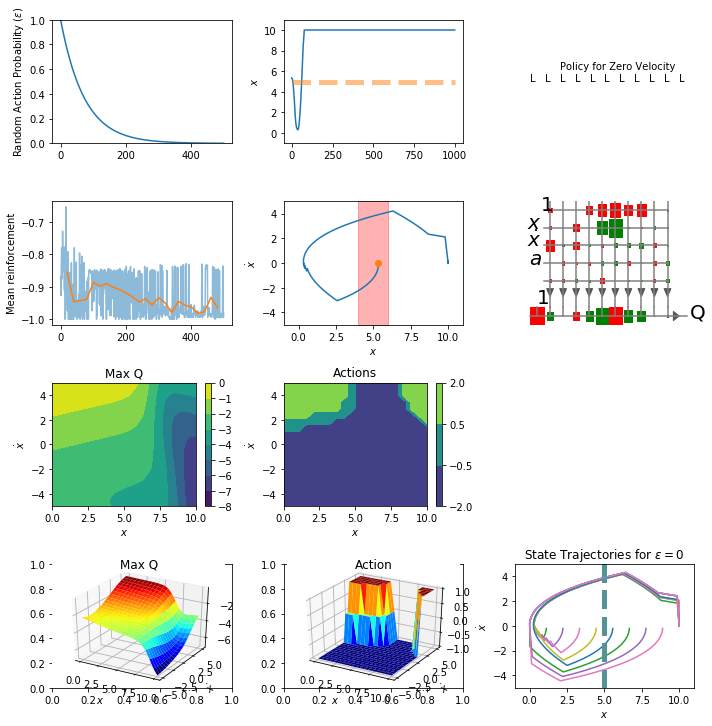

In [28]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.001   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

The value for final epsilon is best fixed at 0.01 as increasing the value to 0.1 gives worse results, in terms of number of positive actions taken to reach the goal position. However, the number of positive actions are still more than the negative actions. Deacreasing the decay rate to 0.001 gives even worse results as the number of negative actions taken to reach the goal is more, thus the time to reach the goal increases, while balancing the marble at the particular position also becomes difficult, as can be seen from the plot.

## for Gamma

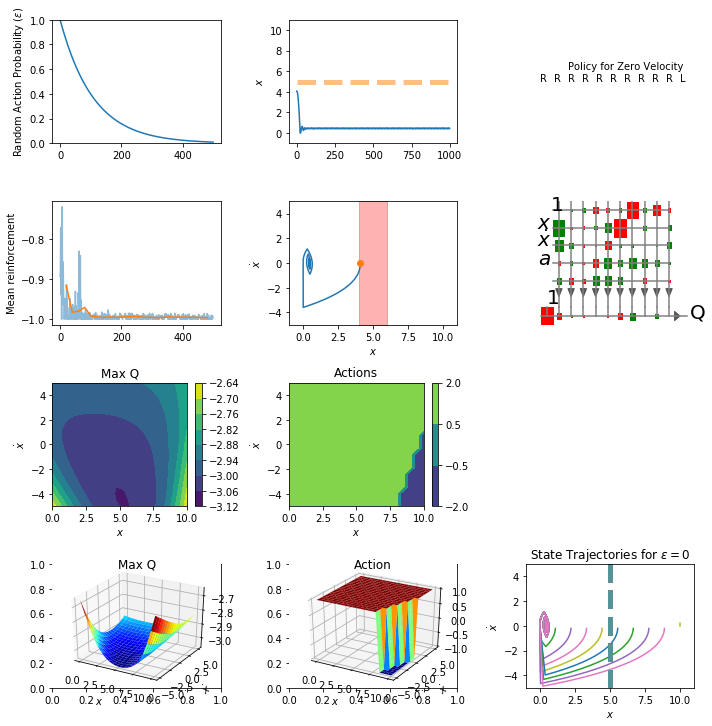

In [29]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.5           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

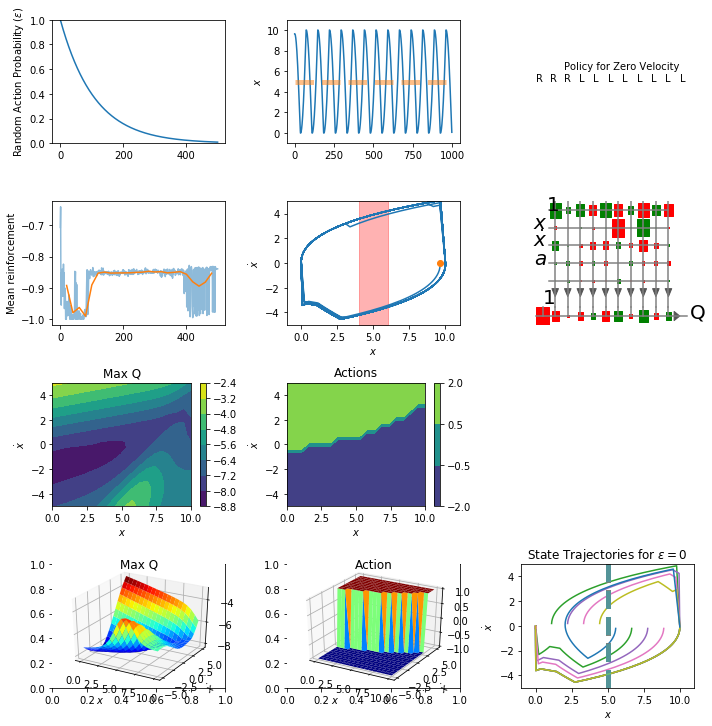

In [9]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.9           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

Decreasing the value of gamma to 0.5 causes an adverse effect on the number of positive actions taken, which is slightly less than gamma=0.8. Increasing the value of gamma, to 0.9, again does not give the best results in terms of positive actions taken, however, controlling the marble is a little easier compared to when the gamma value is less than 0.8.

## for Number of Hidden Units

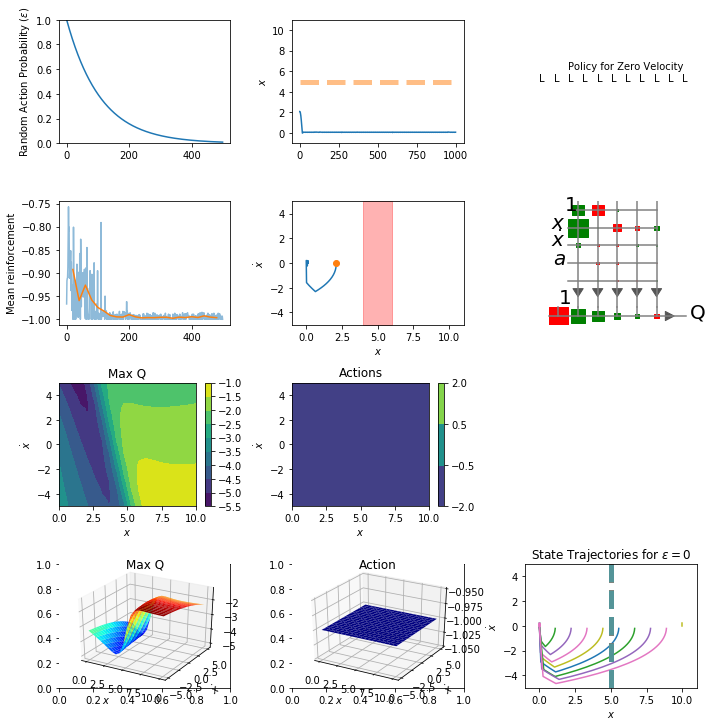

In [31]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [5]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

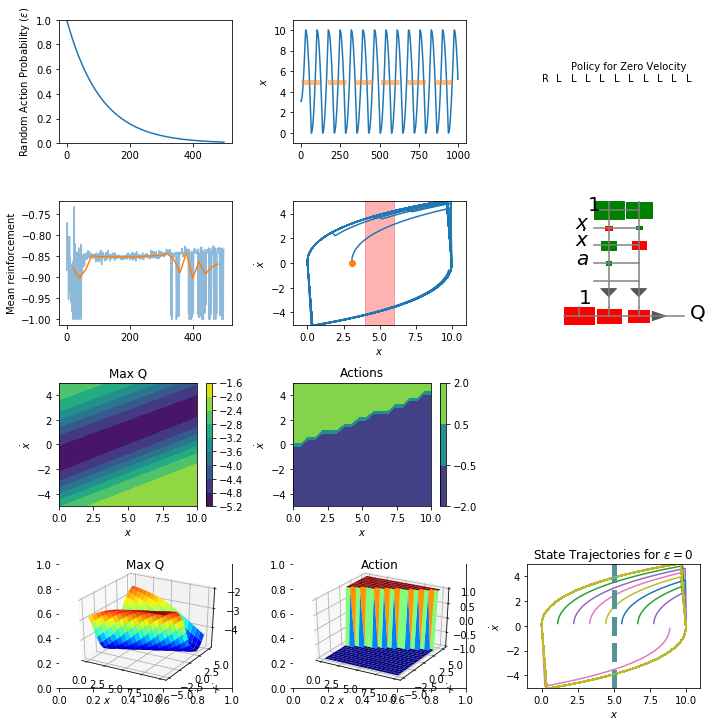

In [32]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [2]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 5
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

Decreasing the number of hidden units from 10 to 5, causes the marble to take a lot of time to reach the goal as the number of negative actions taken is much higher than the number of positive actions taken, however, controlling the marble, i.e getting the marble to stop at position 5 is a bit easier. Decreasing the number of hidden units to 2 however, increases the number of positive actions taken to reach the goal, whereas, controlling the marble is also easier, as seen from the plots above.
The number of hidden layers is reduced as the time required to run the code is very high.

** Made the changes as discussed on Piazza, regarding the error in the grading script. I am still getting that an exception is raised as the 'module' object is not callable.

## Grading

Download [A5grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. 

In [34]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gowaikar-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

######################################################################
Testing

s = initialState(6.6)


--- 20/20 points. initialState correctly returns goal of 6.6 as third component.

######################################################################
Testing

r = reinforcement(np.array([2.8, 2, 3]), np.array([3.6, 1, 3]))


--- 20/20 points. reinforcement correctly returns 0.

######################################################################
Testing

r = reinforcement(np.array([7., 2., 3.]), np.array([8., 1., 3.]))


--- 20/20 points. reinforcement correctly returns -1.

######################################################################
Testing

s_next = nextState(np.array([1.0, 0.0, 7.0]), 1.0)



--- 0/10 points. raised the excepti

<Figure size 432x288 with 0 Axes>

## Extra Credit

One point of extra credit will be given for completing each of the following things.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plane.
* Increase the number of valid actions from three to seven and discuss the difference between the required runs and these new runs.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.  Full extra credit points will only be awarded if you clearly describe your work and results for each point.

In [55]:
validActions = np.array([[0,0],[0.25,np.sqrt(3)/4],[0.5,0],[0.25,-np.sqrt(3)/4],
                         [-0.25,-np.sqrt(3)/4],[-0.5,0],[-0.25,np.sqrt(3)/4]])

def initialState(goal = None):
    global target
    if goal is None:
        goal = random.randint(1,9)
    target = goal
    return np.array([20*np.random.random_sample()-10, 20*np.random.random_sample()-10, 
                     3*(0.5-np.random.random_sample()), 3*(0.5-np.random.random_sample()),0,6,1,0]);

def nextState(s,a):
    
    s = copy.copy(s)   
    deltaT = 0.1                         
    s[0] += deltaT * s[2]                  
    s[1] += deltaT * s[3]                  
    s[4] += deltaT * s[6]                  
    s[5] += deltaT * s[7]   
    
    ax,ay = validActions[a]
    
    marble = s[0]*s[0] + s[1]*s[1]
    
    if marble < 0.0001:  
        marble  = 0.00009
    
    goal = s[4]*s[4] + s[5]*s[5]
    W = 1                        # Wind Speed                 
    
    wxm = -W*s[0]/marble            
    wym = -W*s[1]/marble            
    wxg = -W*s[4]/goal          
    wyg = -W*s[5]/goal         
    
    s[2] += deltaT * (ax + wxm)       
    s[3] += deltaT * (ay + wym)       
    s[6] += deltaT * wxg              
    s[7] += deltaT * wyg              
    
    if s[0] < -10:    
        s = np.array([-10,s[1],0,s[3],s[4],s[5],s[6],s[7]])
    
    elif s[0] > 10:
        s = np.array([10,s[1],0,s[3],s[4],s[5],s[6],s[7]])
    
    if s[1] < -10:    
        s = np.array([s[0],-10,s[2],0,s[4],s[5],s[6],s[7]])
    
    elif s[1] > 10:
        s = np.array([s[0],10,s[2],0,s[4],s[5],s[6],s[7]])
    
    if marble  < 0.01:   
    
        if marble  < 0.0002:  
            s = np.array([np.random.choice([-9,9]),np.random.choice([-9,9]),s[0],s[1],s[4],s[5],s[6],s[7]])
        
        else: 
            s = np.array([np.random.random_sample()/10-0.05,np.random.random_sample()/10-0.05,s[0]/9,s[1]/9,s[4],s[5],s[6],s[7]])
    
    return s   

def reinforcement(s): 

    distance = np.sqrt((s[0]-s[4])**2 + (s[1]-s[5])**2)
  
    clockwise = (s[1]*s[2]-s[0]*s[3]) > 0
    
    return (-0.1 if clockwise else -0.2) if distance > 5 else 0 if distance > 3 else 0.1 if distance > 2 else 0.2


In [56]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace):
    plt.subplot(5,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(5,3,2)
    plt.plot(X[:,0])
    plt.plot(X[:,4],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-11,11)
    plt.subplot(5,3,6)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.plot(X[:,4],X[:,5],'--',alpha=0.5,lw=5)
    plt.plot(X[0,4],X[0,5],'o',alpha=0.5,lw=5)
    plt.title("Marble and Goal path trial")
    plt.xlim(-11,11)
    plt.ylim(-11,11)
    qs = qnet.use(np.array([[s*2-10,5,0,0,0,6,1,0] + validActions[a].tolist() 
                            for a in range(validActions.shape[0]) for s in range(11)]))
    plt.subplot(5,3,12)
    acts = ["0","1","2","3","4","5","6"]
    actsiByState = np.argmax(qs.reshape((validActions.shape[0],-1)),axis=0)
    for i in range(11):
        plt.text(i*2-10,0,acts[actsiByState[i]])
        plt.xlim(-11,11)
        plt.ylim(-1,1)
    plt.text(-9,0.2,"Greedy Policy for Zero Velocity, y=5, goal at (0,6)")
    plt.axis("off")
    plt.subplot(5,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(5,3,5)
    plt.plot(X[:,1])
    plt.plot(X[:,5],'--',alpha=0.5,lw=5)
    plt.ylabel("$y$")
    plt.ylim(-11,11)
    plt.subplot(5,3,3)
    plt.plot(R[:,0]*10)
    plt.plot(X[:,4],'--',alpha=0.5,lw=5)
    plt.ylabel("reinforcement * 10")
    plt.ylim(-11,11)
    plt.subplot(5,3,9)
    qnet.draw(["$x$","$\dot{x}$","$y$","$\dot{y}$","$gx$","$\dot{gx}$","$gy$","$\dot{gy}$","$a$"],["Q"])

    plt.subplot(5,3,7)
    n = 20
    posx = np.linspace(-10,10,n)
    posy =  np.linspace(-10,10,n)
    xs,ys = np.meshgrid(posx,posy)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],0,0,0,6,1,0] + validActions[a].tolist()
                            for a in range(validActions.shape[0]) for i in range(len(xsflat))]))
    qs = qs.reshape((validActions.shape[0],-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Max Q: goal (0,6), velocity 0")
    plt.subplot(5,3,8)
    acts = np.argmax(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Action: goal (0,6), velocity 0")

    s = plt.subplot(5,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    plt.title("Max Q: goal (0,6), velocity 0")

    s = plt.subplot(5,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    plt.title("Action: goal (0,6), velocity 0")

In [57]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 1
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, goal)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

epsilonDecay is 0.9908319448927676


ValueError: operands could not be broadcast together with shapes (1,9) (4,) 

<Figure size 720x720 with 0 Axes>

In [58]:
validActions = np.array([[0,0],[0.25,np.sqrt(3)/4],[0.5,0],[0.25,-np.sqrt(3)/4],
                         [-0.25,-np.sqrt(3)/4],[-0.5,0],[-0.25,np.sqrt(3)/4]])

def initialState(goal = None):
    global target
    if goal is None:
        goal = random.randint(1,9)
    target = goal
    return np.array([20*np.random.random_sample()-10, 20*np.random.random_sample()-10, 
                     3*(0.5-np.random.random_sample()), 3*(0.5-np.random.random_sample()),0,6,1,0]);

def nextState(s,a):
    
    s = copy.copy(s)   
    deltaT = 0.1                         
    s[0] += deltaT * (2 * a - 0.3 * s[2])   # Update velocity. Includes friction                
    s[1] += deltaT * s[3]                  
    s[4] += deltaT * (2 * a - 0.2 * s[6])   # Update velocity. Includes friction              
    s[5] += deltaT * s[7]   
    
    ax,ay = validActions[a]
    
    marble = s[0]*s[0] + s[1]*s[1]
    
    if marble < 0.0001:  
        marble  = 0.00009
    
    goal = s[4]*s[4] + s[5]*s[5]
    W = 1                        # Wind Speed                 
    
    wxm = -W*s[0]/marble            
    wym = -W*s[1]/marble            
    wxg = -W*s[4]/goal          
    wyg = -W*s[5]/goal         
    
    s[2] += deltaT * (ax + wxm)       
    s[3] += deltaT * (ay + wym)       
    s[6] += deltaT * wxg              
    s[7] += deltaT * wyg              
    
    if s[0] < -10:    
        s = np.array([-10,s[1],0,s[3],s[4],s[5],s[6],s[7]])
    
    elif s[0] > 10:
        s = np.array([10,s[1],0,s[3],s[4],s[5],s[6],s[7]])
    
    if s[1] < -10:    
        s = np.array([s[0],-10,s[2],0,s[4],s[5],s[6],s[7]])
    
    elif s[1] > 10:
        s = np.array([s[0],10,s[2],0,s[4],s[5],s[6],s[7]])
    
    if marble  < 0.01:   
    
        if marble  < 0.0002:  
            s = np.array([np.random.choice([-9,9]),np.random.choice([-9,9]),s[0],s[1],s[4],s[5],s[6],s[7]])
        
        else: 
            s = np.array([np.random.random_sample()/10-0.05,np.random.random_sample()/10-0.05,s[0]/9,s[1]/9,s[4],s[5],s[6],s[7]])
    
    return s   

def reinforcement(s): 

    distance = np.sqrt((s[0]-s[4])**2 + (s[1]-s[5])**2)
  
    clockwise = (s[1]*s[2]-s[0]*s[3]) > 0
    
    return (-0.1 if clockwise else -0.2) if distance > 5 else 0 if distance > 3 else 0.1 if distance > 2 else 0.2


I tried the extra credit, the first 3 points and the last point. Can't get it to run completeley due to the time constraints.